<a href="https://colab.research.google.com/github/aayrm5/Zero_to_GANS/blob/main/02_insurance_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1A2ThHoM0NazJwVWKM9yeLAUXupzqUFaM')

# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [ ]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [52]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [53]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [54]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [55]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [56]:
your_name = 'Riyaz' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [57]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [58]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
457,57,female,32.01975,0,no,14327.337811
1050,44,female,38.80275,1,no,9707.993894
56,58,female,33.41625,2,no,16464.916187
311,19,female,25.93500,0,no,2102.224960
1288,20,male,41.37000,2,yes,46396.924860


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [59]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [60]:
num_cols = dataframe.shape[1]
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [61]:
input_cols = list(dataframe.columns[:-1])
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [62]:
categorical_cols = list(dataframe.select_dtypes('O').columns)
categorical_cols

['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [63]:
output_cols = [dataframe.columns[-1]]
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

           charges
min    1357.467419
max   77162.217892
mean  15876.391392


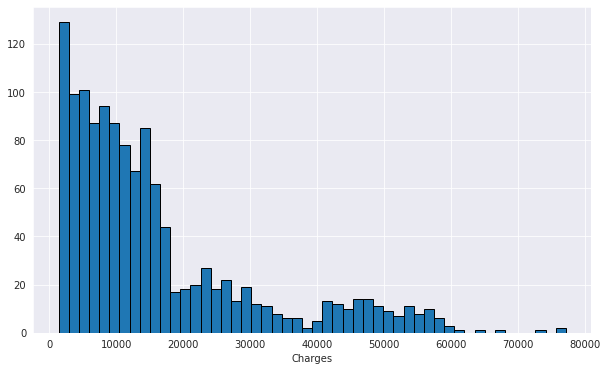

In [64]:
# Write your answer here
print(dataframe.agg({'charges':['min','max','mean']}))
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.hist(dataframe['charges'], bins=50, ec='black')
plt.xlabel('Charges')
plt.show()

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [65]:
!pip install jovian --upgrade -q

In [66]:
import jovian

In [67]:
jovian.commit(project='my-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/aayrm5/my-project


'https://jovian.ai/aayrm5/my-project'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [68]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [69]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[57.     ,  0.     , 32.01975,  0.     ,  0.     ],
        [44.     ,  0.     , 38.80275,  1.     ,  0.     ],
        [58.     ,  0.     , 33.41625,  2.     ,  0.     ],
        ...,
        [59.     ,  0.     , 36.54   ,  2.     ,  0.     ],
        [41.     ,  1.     , 30.24   ,  1.     ,  0.     ],
        [36.     ,  0.     , 31.521  ,  0.     ,  0.     ]]),
 array([[14327.3378105],
        [ 9707.9938945],
        [16464.9161875],
        ...,
        [44661.8357163],
        [ 7601.50435  ],
        [ 6379.332718 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [70]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)
inputs[:2], targets[:2]

(tensor([[57.0000,  0.0000, 32.0197,  0.0000,  0.0000],
         [44.0000,  0.0000, 38.8027,  1.0000,  0.0000]]), tensor([[14327.3379],
         [ 9707.9941]]))

In [71]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [72]:
dataset = TensorDataset(inputs, targets)
dataset[:5]

(tensor([[57.0000,  0.0000, 32.0197,  0.0000,  0.0000],
         [44.0000,  0.0000, 38.8027,  1.0000,  0.0000],
         [58.0000,  0.0000, 33.4162,  2.0000,  0.0000],
         [19.0000,  0.0000, 25.9350,  0.0000,  0.0000],
         [20.0000,  1.0000, 41.3700,  2.0000,  1.0000]]), tensor([[14327.3379],
         [ 9707.9941],
         [16464.9160],
         [ 2102.2249],
         [46396.9258]]))

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [73]:
val_percent = 0.125 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [74]:
batch_size = 120

In [75]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
len(train_loader), len(val_loader)

(10, 2)

Let's look at a batch of data to verify everything is working fine so far.

In [76]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[29.0000,  1.0000, 35.0122,  2.0000,  0.0000],
        [22.0000,  0.0000, 21.2467,  0.0000,  0.0000],
        [23.0000,  1.0000, 19.6507,  0.0000,  0.0000],
        [18.0000,  0.0000, 37.4062,  0.0000,  0.0000],
        [61.0000,  1.0000, 24.8377,  0.0000,  0.0000],
        [28.0000,  0.0000, 18.1545,  0.0000,  0.0000],
        [62.0000,  0.0000, 41.1180,  0.0000,  0.0000],
        [24.0000,  1.0000, 33.6105,  0.0000,  0.0000],
        [60.0000,  1.0000, 25.5360,  0.0000,  0.0000],
        [23.0000,  1.0000, 33.3165,  3.0000,  1.0000],
        [22.0000,  0.0000, 31.9200,  0.0000,  0.0000],
        [21.0000,  1.0000, 37.3065,  0.0000,  0.0000],
        [19.0000,  0.0000, 29.2950,  0.0000,  1.0000],
        [22.0000,  0.0000, 29.4525,  0.0000,  0.0000],
        [44.0000,  1.0000, 23.2418,  2.0000,  0.0000],
        [33.0000,  1.0000, 28.4550,  1.0000,  1.0000],
        [62.0000,  0.0000, 32.0197,  2.0000,  0.0000],
        [39.0000,  0.0000, 34.4400,  0.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [77]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/aayrm5/02-insurance-linear-regression


'https://jovian.ai/aayrm5/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [78]:
inputs.size(), targets.size()

(torch.Size([1271, 5]), torch.Size([1271, 1]))

In [79]:
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

In [80]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(5, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [81]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)        
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [82]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [83]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0627, -0.0439,  0.3728, -0.4229,  0.3915]], requires_grad=True),
 Parameter containing:
 tensor([-0.3722], requires_grad=True)]

One final commit before we train the model.

In [84]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/aayrm5/02-insurance-linear-regression


'https://jovian.ai/aayrm5/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [85]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [86]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 16672.537109375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [87]:
epochs = 2000
lr = 1e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15226.4375
Epoch [40], val_loss: 13808.7129
Epoch [60], val_loss: 12618.1855
Epoch [80], val_loss: 11706.9805
Epoch [100], val_loss: 11024.8633
Epoch [120], val_loss: 10514.4570
Epoch [140], val_loss: 10188.2803
Epoch [160], val_loss: 10015.3027
Epoch [180], val_loss: 9925.4199
Epoch [200], val_loss: 9885.5820
Epoch [220], val_loss: 9858.3750
Epoch [240], val_loss: 9841.5059
Epoch [260], val_loss: 9824.1094
Epoch [280], val_loss: 9805.3398
Epoch [300], val_loss: 9785.4980
Epoch [320], val_loss: 9762.6289
Epoch [340], val_loss: 9738.9746
Epoch [360], val_loss: 9712.2617
Epoch [380], val_loss: 9684.8057
Epoch [400], val_loss: 9657.1709
Epoch [420], val_loss: 9626.6484
Epoch [440], val_loss: 9597.7148
Epoch [460], val_loss: 9564.0645
Epoch [480], val_loss: 9532.9512
Epoch [500], val_loss: 9499.3311
Epoch [520], val_loss: 9468.2627
Epoch [540], val_loss: 9436.1553
Epoch [560], val_loss: 9404.1465
Epoch [580], val_loss: 9373.4805
Epoch [600], val_loss: 9344.7168
Epoch 

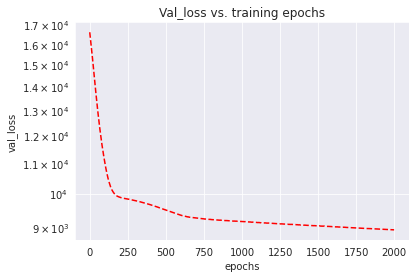

In [123]:
val_loss_list = [l['val_loss'] for l in history1]
plt.plot(val_loss_list,'r--')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.yscale('log')
plt.title('Val_loss vs. training epochs')
plt.show()

In [94]:
epochs = 3000
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8924.9951
Epoch [40], val_loss: 8924.1191
Epoch [60], val_loss: 8924.0117
Epoch [80], val_loss: 8923.1631
Epoch [100], val_loss: 8923.1299
Epoch [120], val_loss: 8922.6719
Epoch [140], val_loss: 8921.7949
Epoch [160], val_loss: 8921.5566
Epoch [180], val_loss: 8921.4316
Epoch [200], val_loss: 8920.7900
Epoch [220], val_loss: 8920.0508
Epoch [240], val_loss: 8919.6123
Epoch [260], val_loss: 8919.1865
Epoch [280], val_loss: 8919.1768
Epoch [300], val_loss: 8918.5039
Epoch [320], val_loss: 8918.0186
Epoch [340], val_loss: 8917.4863
Epoch [360], val_loss: 8916.5508
Epoch [380], val_loss: 8916.5625
Epoch [400], val_loss: 8916.0869
Epoch [420], val_loss: 8915.6211
Epoch [440], val_loss: 8915.5293
Epoch [460], val_loss: 8914.8896
Epoch [480], val_loss: 8914.3398
Epoch [500], val_loss: 8913.6436
Epoch [520], val_loss: 8913.2344
Epoch [540], val_loss: 8912.8320
Epoch [560], val_loss: 8912.3926
Epoch [580], val_loss: 8912.1299
Epoch [600], val_loss: 8911.0000
Epoch [620], v

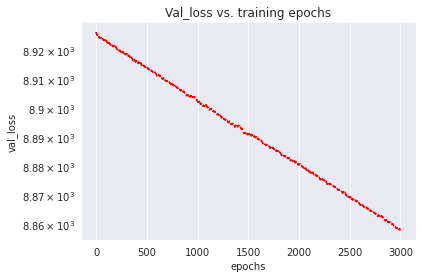

In [124]:
val_loss_list = [l['val_loss'] for l in history2]
plt.plot(val_loss_list,'r--')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.yscale('log')
plt.title('Val_loss vs. training epochs')
plt.show()

In [96]:
epochs = 3000
lr = 1e-3
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8858.1660
Epoch [40], val_loss: 8858.1094
Epoch [60], val_loss: 8858.0264
Epoch [80], val_loss: 8857.9766
Epoch [100], val_loss: 8857.8965
Epoch [120], val_loss: 8857.9082
Epoch [140], val_loss: 8857.9268
Epoch [160], val_loss: 8857.8730
Epoch [180], val_loss: 8857.7881
Epoch [200], val_loss: 8857.7676
Epoch [220], val_loss: 8857.6475
Epoch [240], val_loss: 8857.5859
Epoch [260], val_loss: 8857.6211
Epoch [280], val_loss: 8857.5527
Epoch [300], val_loss: 8857.5225
Epoch [320], val_loss: 8857.4668
Epoch [340], val_loss: 8857.3613
Epoch [360], val_loss: 8857.3184
Epoch [380], val_loss: 8857.3164
Epoch [400], val_loss: 8857.2764
Epoch [420], val_loss: 8857.2627
Epoch [440], val_loss: 8857.1523
Epoch [460], val_loss: 8857.1094
Epoch [480], val_loss: 8857.1699
Epoch [500], val_loss: 8857.1270
Epoch [520], val_loss: 8857.0820
Epoch [540], val_loss: 8857.1436
Epoch [560], val_loss: 8857.0654
Epoch [580], val_loss: 8857.0703
Epoch [600], val_loss: 8856.9600
Epoch [620], v

Text(0.5, 1.0, 'Val_loss vs. training epochs')

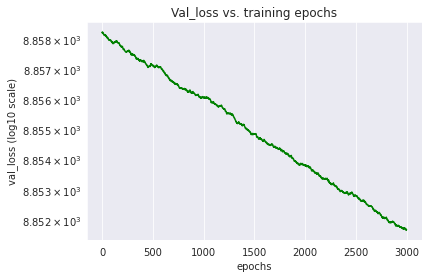

In [108]:
val_loss_list = [l['val_loss'] for l in history3]
plt.plot(val_loss_list,'r--')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.yscale('log')
plt.title('Val_loss vs. training epochs')
plt.show()

In [97]:
epochs = 3000
lr = 1e-1
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8845.8154
Epoch [40], val_loss: 8842.7744
Epoch [60], val_loss: 8838.3623
Epoch [80], val_loss: 8833.6797
Epoch [100], val_loss: 8829.4131
Epoch [120], val_loss: 8824.8809
Epoch [140], val_loss: 8822.5244
Epoch [160], val_loss: 8816.0703
Epoch [180], val_loss: 8812.4209
Epoch [200], val_loss: 8809.0967
Epoch [220], val_loss: 8804.3760
Epoch [240], val_loss: 8800.8818
Epoch [260], val_loss: 8795.6914
Epoch [280], val_loss: 8792.5898
Epoch [300], val_loss: 8787.3975
Epoch [320], val_loss: 8782.1387
Epoch [340], val_loss: 8777.9951
Epoch [360], val_loss: 8773.7441
Epoch [380], val_loss: 8769.7148
Epoch [400], val_loss: 8766.5488
Epoch [420], val_loss: 8760.4902
Epoch [440], val_loss: 8756.4883
Epoch [460], val_loss: 8751.8174
Epoch [480], val_loss: 8748.9551
Epoch [500], val_loss: 8744.1387
Epoch [520], val_loss: 8739.8730
Epoch [540], val_loss: 8735.7246
Epoch [560], val_loss: 8732.0479
Epoch [580], val_loss: 8727.0469
Epoch [600], val_loss: 8723.7285
Epoch [620], v

Text(0.5, 1.0, 'Val_loss vs. training epochs')

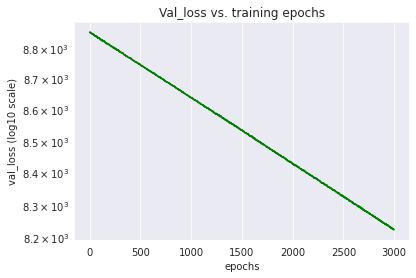

In [109]:
val_loss_list = [l['val_loss'] for l in history4]
plt.plot(val_loss_list,'r--')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.yscale('log')
plt.title('Val_loss vs. training epochs')
plt.show()

In [98]:
epochs = 3000
lr = 1e-5
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8224.0977
Epoch [40], val_loss: 8224.0977
Epoch [60], val_loss: 8224.0967
Epoch [80], val_loss: 8224.0967
Epoch [100], val_loss: 8224.0957
Epoch [120], val_loss: 8224.0967
Epoch [140], val_loss: 8224.0967
Epoch [160], val_loss: 8224.0967
Epoch [180], val_loss: 8224.0967
Epoch [200], val_loss: 8224.0957
Epoch [220], val_loss: 8224.0957
Epoch [240], val_loss: 8224.0957
Epoch [260], val_loss: 8224.0957
Epoch [280], val_loss: 8224.0947
Epoch [300], val_loss: 8224.0957
Epoch [320], val_loss: 8224.0947
Epoch [340], val_loss: 8224.0938
Epoch [360], val_loss: 8224.0938
Epoch [380], val_loss: 8224.0938
Epoch [400], val_loss: 8224.0938
Epoch [420], val_loss: 8224.0938
Epoch [440], val_loss: 8224.0938
Epoch [460], val_loss: 8224.0938
Epoch [480], val_loss: 8224.0938
Epoch [500], val_loss: 8224.0928
Epoch [520], val_loss: 8224.0938
Epoch [540], val_loss: 8224.0928
Epoch [560], val_loss: 8224.0928
Epoch [580], val_loss: 8224.0918
Epoch [600], val_loss: 8224.0918
Epoch [620], v

Text(0.5, 1.0, 'Val_loss vs. training epochs')

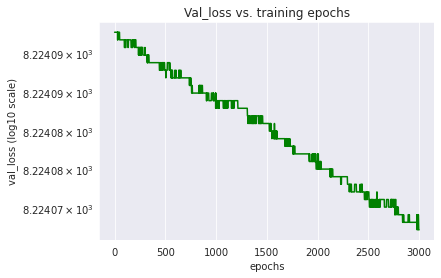

In [110]:
val_loss_list = [l['val_loss'] for l in history5]
plt.plot(val_loss_list,'r--')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.yscale('log')
plt.title('Val_loss vs. training epochs')
plt.show()

**Q: What is the final validation loss of your model?**

{'val_loss': 8224.072265625}


Text(0.5, 1.0, 'Val_loss vs. training epochs')

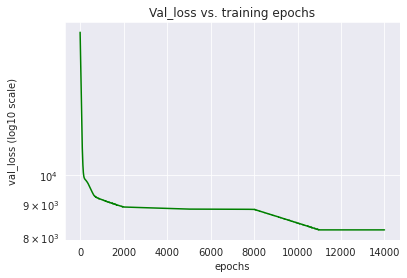

In [111]:
val_loss = evaluate(model, val_loader)
print(val_loss)
val_loss_history = [result] + history1 + history2 + history3 + history4 + history5
val_loss_list = [vl['val_loss'] for vl in val_loss_history]
plt.plot(val_loss_list, '-g')
plt.xlabel('epochs')
plt.ylabel('val_loss (log10 scale)')
plt.yscale('log')  # linear scale is not very representative
plt.title('Val_loss vs. training epochs')

In [100]:
val_loss = history5[-1]['val_loss']
val_loss

8224.072265625

Let's log the final validation loss to Jovian and commit the notebook

In [ ]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/aayrm5/02-insurance-linear-regression


'https://jovian.ai/aayrm5/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [112]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [113]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([53.0000,  0.0000, 24.9375,  2.0000,  0.0000])
Target: tensor([14192.9121])
Prediction: tensor(14342.9883)


In [114]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([20.0000,  0.0000, 33.5160,  0.0000,  0.0000])
Target: tensor([2736.4983])
Prediction: tensor(2577.4795)


In [115]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([19.0000,  1.0000, 26.4338,  0.0000,  0.0000])
Target: tensor([1974.7639])
Prediction: tensor(1986.1943)


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [116]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/aayrm5/02-insurance-linear-regression
[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/aayrm5/02-insurance-linear-regression


'https://jovian.ai/aayrm5/02-insurance-linear-regression'

In [117]:
jovian.submit(project='my-project',assignment="zerotogans-a2")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/aayrm5/my-project
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model
